<H1> Introdução </H1>
<p> 
    Os dados analisados aqui estão disponíveis no site do Instituto Nacional de Metereologia (INMET) em formato CSV e podem ser baixados através <a href="https://portal.inmet.gov.br/dadoshistoricos"> deste link </a> e por isso não foram incluídos no repositório. 
</p>

<p> 
    Os dados foram mantidos na organização original, com as tabelas divididas em pastas por ano e em arquivos segundo o local de medição. 
</p>

<p> Uma lista de todos os arquivos disponíveis foi salva no arquivo <i> files.txt </i> para facilitar a consulta dos mesmos e para permitir a quem esteja acessando este repositório consultar rapidamente quais arquivos estão disponíveis sem necessidade de baixá-los no site do INMET. </p>

<p> 
Os dados de 2024 não foram incluídos pois no momento em que este repositório foi criado o ano ainda não tinha acabado. Estes dados serão incluídos em algum momento no futuro. 
</p>

In [1]:
# Bibliotecas utilizadas
from datetime import datetime
from collections import Counter
import json
import geopandas
from IPython.display import display, HTML
import pyogrio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

<h1> Sobre os dados</h1>
<p> Cada arquivo CSV contém dados recolhidos a cada hora em um único local de medição durante um período máximo de um ano.</p>
<p> O período observado em cada arquivo sempre segue o ano civil. Deste modo, não há dados de dois anos diferentes em um mesmo arquivo. </p>
<p> O nome dos arquivos é padronizado no formato <i>INMET_SiglaRegiao_SiglaEstado_Codigo_Local_DataInicial_A_DataFinal.csv </i> (em letras maiúsculas), que é fácil de ser lido e que descreve os metadados dos mesmos, possibilitando uma rápida recuperação das informações desejadas. </p>
<p> <b>Observações:</b> <br> 
    1. Algumas poucas cidades possuem mais de um local de medição, mas por simplicidade será utilizado apenas o termo 'Cidade' para se referir aos locais nas tabelas e gráficos a seguir. <br>
    2. Existem três arquivos de dados de medições no Pelotão Especial de Fronteira de Bonfim, em Roaraima, que não correspondem ao padrão mencionado acima. 
</p>

In [2]:
# Lê a lista de arquivos e criar um dataframe com os dados. 
file = open("files.txt", "r")
file_content = file.read()
file_list = [x for x in file_content.splitlines() if len(x) > 2]

# O SEGUNDO REPLACE É PARA CORRIGIR O PROBLEMA DA OBSERVAÇÃO 2 ACIMA.
file_list_splitted = [ x.replace(".CSV","").replace("EB_PEF_BONFIM", "EB PEF BONFIM").strip().split('_')[0 : 8] + [x] for x in file_list]
df_files = pd.DataFrame(columns=["INMET", "REGIAO", "ESTADO", "CODIGO", "CIDADE", "DATA INI", "A", "DATA FIM", "ARQUIVO"],
                        data = file_list_splitted).drop(columns={"INMET", "A"})
# Mostra a tabela co
display(df_files)

,REGIAO,ESTADO,CODIGO,CIDADE,DATA INI,DATA FIM,ARQUIVO
0,CO,DF,A001,BRASILIA,07-05-2000,31-12-2000,INMET_CO_DF_A001_BRASILIA_07-05-2000_A_31-12-2...
1,NE,BA,A401,SALVADOR,13-05-2000,31-12-2000,INMET_NE_BA_A401_SALVADOR_13-05-2000_A_31-12-2...
2,N,AM,A101,MANAUS,09-05-2000,31-12-2000,INMET_N_AM_A101_MANAUS_09-05-2000_A_31-12-2000...
3,SE,RJ,A601,ECOLOGIA AGRICOLA,07-05-2000,31-12-2000,INMET_SE_RJ_A601_ECOLOGIA AGRICOLA_07-05-2000_...
4,S,RS,A801,PORTO ALEGRE,22-09-2000,31-12-2000,INMET_S_RS_A801_PORTO ALEGRE_22-09-2000_A_31-1...
...,...,...,...,...,...,...,...
8889,S,SC,A867,ARARANGUA,01-01-2023,31-12-2023,INMET_S_SC_A867_ARARANGUA_01-01-2023_A_31-12-2...
8890,S,SC,A868,ITAJAI,01-01-2023,31-12-2023,INMET_S_SC_A868_ITAJAI_01-01-2023_A_31-12-2023...
8891,S,SC,A870,RANCHO QUEIMADO,01-01-2023,31-12-2023,INMET_S_SC_A870_RANCHO QUEIMADO_01-01-2023_A_3...
8892,S,SC,A895,CHAPECO,01-01-2023,31-12-2023,INMET_S_SC_A895_CHAPECO_01-01-2023_A_31-12-202...


<h2>Dados sobre os locais de medição</h2>

In [3]:
print(f"Existem dados de {len(df_files['CIDADE'].unique())} locais diferentes")

Existem dados de 632 locais diferentes


In [4]:
composed_places = [y[0] for y in [x.split(' - ') for x in df_files[df_files['CIDADE'].str.contains(' - ')]['CIDADE'].unique()]] +\
                  [y[0] for y in [x.split(' (') for x in df_files[df_files['CIDADE'].str.contains('\(')]['CIDADE'].unique()]]

duplicated_cities = pd.concat([pd.Series(df_files[df_files['CIDADE'].isin(composed_places)]['CIDADE'].unique()),\
                               pd.Series([item for item, count in Counter(composed_places).items() if count > 1])]).to_list()
print("Cidades com mais de um local de medição: " + ', '.join(duplicated_cities))

Cidades com mais de um local de medição: SALVADOR, PORTO ALEGRE, CRISTALINA, NOVA FRIBURGO, SAQUAREMA, CAMPOS DOS GOYTACAZES, SAO PAULO, BELO HORIZONTE, RIO DE JANEIRO, BRASNORTE


In [5]:
# FUNCAO PARA DEFINIR AS CORES DA PRIMEIRA COLUNA EM TABELAS COM AGRUPAMENTO + REORDANAÇÂO DE DADOS
def color(x):
    no_repetitions = x.unique()
    return ["background-color: #f5f5f5; background: #f5f5f5" if np.where(no_repetitions == el)[0]%2 == 0 \
            else "background-color: #ffffff; background: #ffffff" for  index, el in x.items()]

In [6]:
# EXIBIÇÃO RESUMIDA DAS LOCALIDADES MONITORADAS POR REGIÃO E ESTADO. 
display(df_files[['REGIAO', 'ESTADO', 'CIDADE']]\
            .groupby(by=['REGIAO','ESTADO'])\
            .agg(['nunique', lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])])\
            .sort_values(by=['REGIAO', ('CIDADE','<lambda_0>')], ascending=[True,False])\
            .rename(columns={ 'nunique': 'NÚMERO DE CIDADES', '<lambda_0>': 'CIDADES'}, level=1)\
            .droplevel(0, axis=1)\
            .style.set_properties(**{'text-align': 'left'}, subset='CIDADES')\
            .set_properties(**{'text-align': 'center'}, subset='NÚMERO DE CIDADES')\
            .apply_index(color, axis=0, level =[0]))\
            


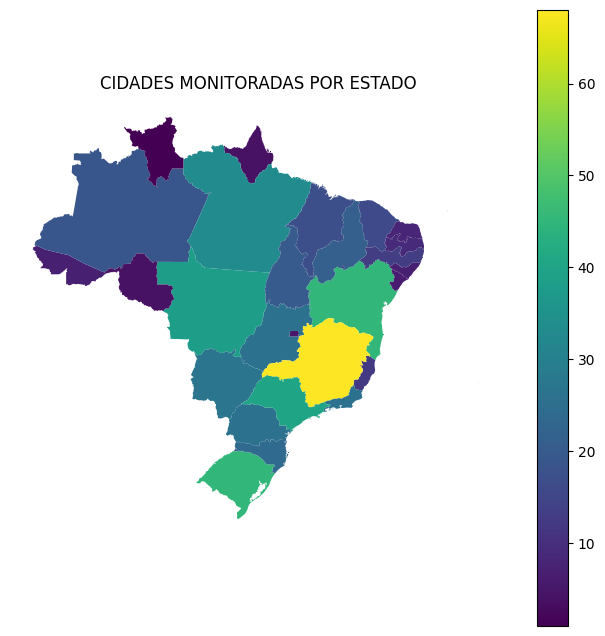

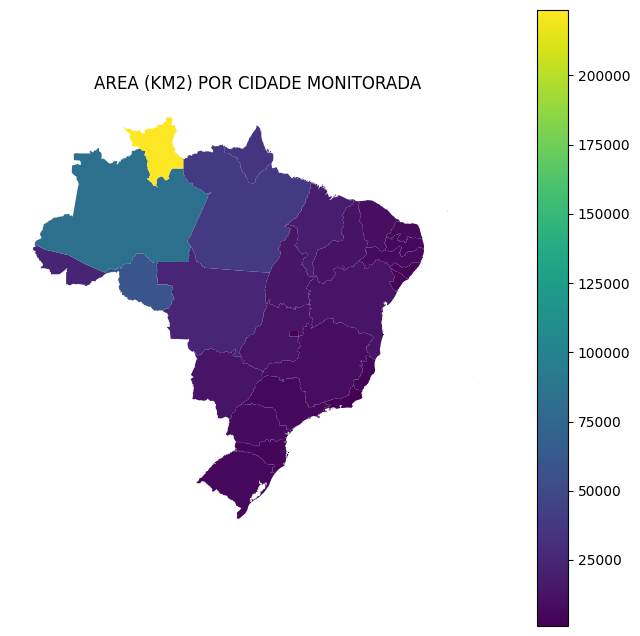

In [35]:
df_area_estados = pd.read_csv("area_estados.csv", sep=";", decimal=',')
df_mapa = df_files[df_files['ANO'] == 2023][['ESTADO', 'CIDADE']]\
            .groupby(by='ESTADO')\
            .agg('nunique').merge(df_area_estados, on='ESTADO')\
            .assign(**{'AREA (KM2) POR CIDADE MONITORADA': lambda x : round(x.AREA/x.CIDADE, 1)})\
            .sort_values(by= 'AREA (KM2) POR CIDADE MONITORADA', ascending=False).reset_index(drop=True)

estados_geojson = geopandas.read_file('./geojson/brasil_estados.json')
estados_geojson['ESTADO'] = estados_geojson['id']
estados_geojson = estados_geojson.merge(df_mapa, on='ESTADO')

ax = estados_geojson.plot(column='CIDADE', legend=True, figsize = (8, 8));
ax.set_axis_off()
ax.set_title('CIDADES MONITORADAS POR ESTADO');

ax = estados_geojson.plot(column='AREA (KM2) POR CIDADE MONITORADA', legend=True, figsize = (8, 8));
ax.set_axis_off()
ax.set_title('AREA (KM2) POR CIDADE MONITORADA');

In [36]:
display(df_mapa)

,ESTADO,CIDADE,AREA,AREA (KM2) POR CIDADE MONITORADA
0,RR,1,223644.527,223644.5
1,AM,19,1559167.889,82061.5
2,RO,4,237765.240,59441.3
3,PA,33,1245870.798,37753.7
4,AP,4,142470.762,35617.7
5,MT,38,903207.019,23768.6
6,AC,7,164123.964,23446.3
7,MA,17,329642.182,19390.7
8,TO,20,277466.763,13873.3
9,MS,27,357145.534,13227.6


<H2> Histórico das medições </H2>
<p> Nesta seção podemos ver a evolução do número de estações durante todo o período de monitoramento e quais cidades/locais começaram a ser monitoradas em cada ano. </p>

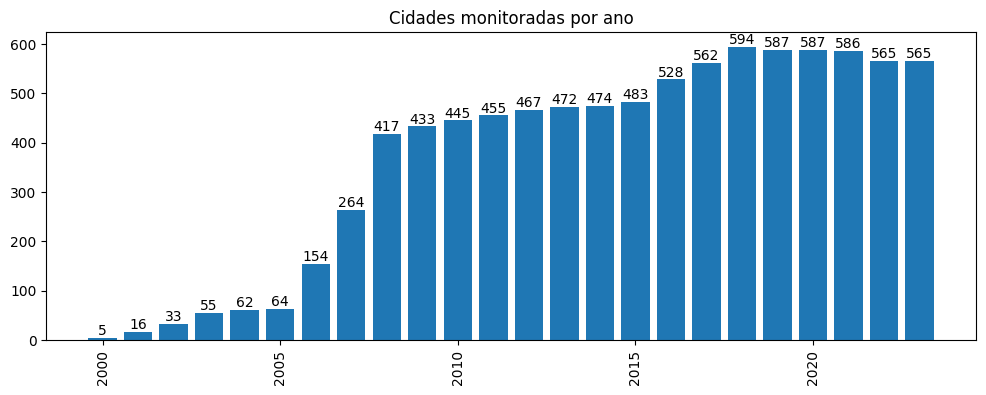

In [9]:
df_files['ANO'] = [int(x.split('-')[-1]) for x in df_files['DATA INI']]
df_files = df_files.sort_values(by='ANO')
cities_by_year = df_files[['ANO', 'CIDADE']]\
            .groupby(by='ANO')\
            .agg({'CIDADE': ['nunique', lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])]})\
            .rename(columns={ 'nunique': 'NÚMERO DE CIDADES', '<lambda_0>': 'CIDADES'}, level=1)\
            .droplevel(0, axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(12, 4);
plt.xticks(rotation = 90)
ax.set_title('Cidades monitoradas por ano')
ax.bar(cities_by_year.index, cities_by_year['NÚMERO DE CIDADES']);
ax.bar_label(ax.containers[-1]);


<p> Pelo gráfico acima podemos ver que houve um salto no número de locais monitorados entre 2005 e 2008 e depois entre 2015 e 2018. <p>
<p> Abaixo temos um gráfico mostrando a evolução do monitoramento em cada região. </p>

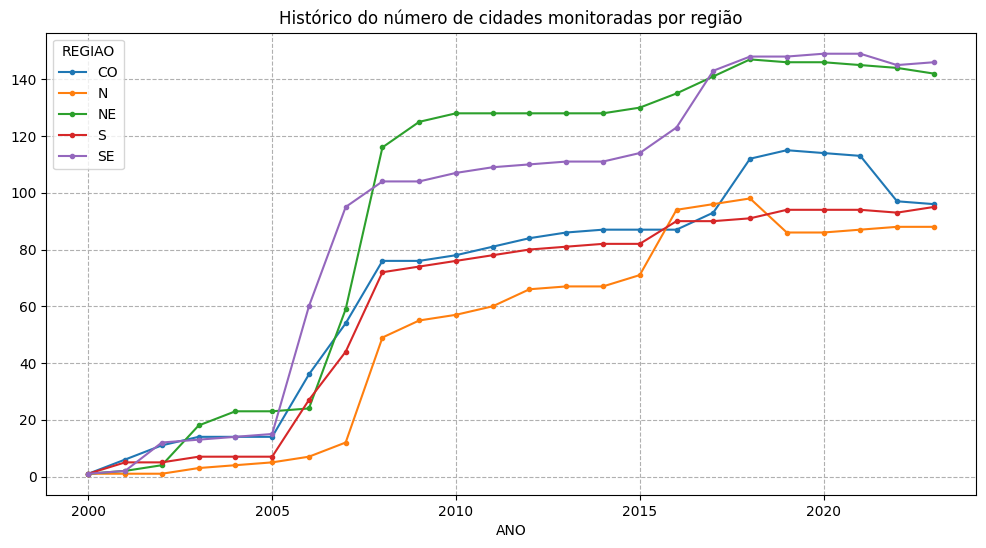

In [10]:
df_files[["REGIAO", "ANO", "ARQUIVO"]].groupby(by=["ANO", "REGIAO"]).count()\
        .unstack(level=1).droplevel(level=0, axis=1)\
        .plot(title="Histórico do número de cidades monitoradas por região", label="ANO", figsize = (12, 6), marker='.')\
        .grid(linestyle = '--');

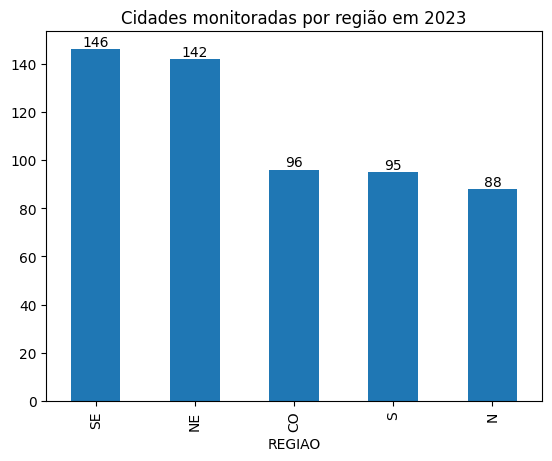

In [11]:
ax = df_files[df_files["ANO"] == 2023][["REGIAO", "ARQUIVO"]]\
                .groupby(by="REGIAO").count().sort_values(by="ARQUIVO", ascending=False)\
                .plot(kind="bar", title="Cidades monitoradas por região em 2023")
ax.bar_label(ax.containers[0]);
ax.legend().remove();

In [12]:
# EXTRAI O ANO INICIAL E FINAL DE MONITORAMENTO EM CADA CIDADE (last, first) E DEPOIS AGRUPA POR ANO DE INICIO
# A PENÚLTIMA LINHA É INSERIDA PARA EXPANDIR A TABELA
display(df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'last', 'first'})\
        .rename(columns={'first': 'ANO INICIO', 'last': 'ANO FIM'})\
        .droplevel(0, axis = 1).reset_index()[['CIDADE', 'ANO INICIO']]\
        .groupby(by='ANO INICIO').agg({'CIDADE':  lambda col: ',  '.join([x.title() for x in col.sort_values().unique()])   })\
        .style.set_properties(**{'text-align': 'left'})
        .apply_index(color, axis=0, level =[0]))

,CIDADE
ANO INICIO,
2000,"Brasilia, Ecologia Agricola, Manaus, Porto Alegre, Salvador"
2001,"Barreiras, Bauru, Campo Grande, Goiania, Morrinhos, Ponta Pora, Rio Grande, Santa Maria, Santana Do Livramento, Santo Augusto, Tres Lagoas"
2002,"Almenara, Araxa, Barbacena, Cambuci, Campo Novo Dos Parecis, Campos Do Jordao, Caravelas, Cuiaba, Franca, Guaranta Do Norte, Luiz Eduardo Magalhaes, Marambaia, Montes Claros, Sorriso, Tangara Da Serra, Uberlandia, Xerem"
2003,"Aracaju, Arq.Sao Pedro E Sao Paulo, Belem, Castanhal, Cruz Das Almas, Curitiba, Florianopolis, Fortaleza, Ilheus, Itaberaba, Itirucu, Ivinhema, Macajuba, Maceio, Natal, Parnaiba, Petrolina, Presidente Prudente, Rondonopolis, S.J. Do Rio Claro, Sao Luis, Sobral"
2004,"Arco Verde, Areia, Floriano, Monte Verde, Palmas, Recife, Teresina"
2005,"Parana, Vicosa"
2006,"Agua Boa, Alegre, Alegrete, Alfredo Chaves, Apiacas, Aquidauana, Arraial Do Cabo, Avare, Bento Goncalves, Cacapava Do Sul, Caldas, Camaqua, Campina Grande, Campina Verde, Campo Verde, Campos, Castro, Chapadao Do Sul, Comodoro, Conceicao Das Alagoas, Corumba, Coxim, Curvelo, Dourados, Erechim, Formiga, Gurupi, Icaraima, Iguape, Inacio Martins, Indaial, Itapeva, Ituiutaba, Ivai, Joaquim Tavora, Juara, Juina, Linhares, Lins, Luziania, Macae, Mal. Candido Rondon, Maracaju, Maria Da Fe, Maringa, Miranda, Muriae, Nhumirim, Nova Tebas, Ourinhos, Ouro Branco, Pampulha, Paranaiba, Paranatinga, Parati, Passo Fundo, Passos, Patrocinio, Peixe, Pico Do Couto, Piracicaba, Porto Murtinho, Rancharia, Resende, Rio Pardo, Sacramento, Santa Rosa, Sao Carlos, Sao Gabriel Do Oeste, Sao Joao Del Rei, Sao Jose Dos Ausentes, Sao Mateus, Sao Miguel Arcanjo, Sao Paulo - Mirante, Sao Simao, Serra Dos Aimores, Sinop, Sorocaba, Taubate, Teofilo Otoni, Teresopolis, Timoteo, Torres, Tres Marias, Uruguaiana, Valenca, Varginha, Vila Bela Da Santissima Trindade, Vitoria, Votuporanga"
2007,"Aguas Vermelhas, Aimores, Alta Floresta, Alto Paraiso De Goias, Alvorada Do Gurgueia, Apodi, Aragarcas, Araguaina, Ariranha, Bage, Balsas, Barbalha, Bom Jardim Da Serra - Morro Da Igreja, Bom Jesus Da Lapa, Bom Jesus Do Piaui, Buritis, Cabrobo, Caiaponia, Caico, Cangucu, Capelinha, Caracol, Caratinga, Carolina, Caruaru, Casa Branca, Chapada Gaucha, Correntina, Cotriguacu, Cristalina, Cruz Alta, Diamantina, Dois Vizinhos, Dores Do Indaia, Esperantina, Espinosa, Feira De Santana, Forte De Copacabana, Frederico Westphalen, Garanhuns, Goianesia, Goias, Governador Valadares, Guanhaes, Guaramiranga, Guarda-Mor, Ibitinga, Iguatu, Ilha Do Mel, Itabaianinha, Itaobim, Itapaci, Itapira, Itapoa, Itumbiara, Jaguarao, Jaguaruana, Jales, Jatai, Joacaba, Joao Pessoa, Joao Pinheiro, Jose Bonifacio, Juiz De Fora, Lagoa Vermelha, Macau, Mantena, Mineiros, Mocambinho, Montalvania, Monte Alegre De Goias, Monteiro, Morada Nova, Mossoro, Nova Fatima, Palmeira Dos Indios, Pao De Acucar, Paragominas, Passa Quatro, Patos, Paulistana, Pedro Afonso, Pirapora, Pires Do Rio, Piripiri, Planalto, Porto Velho, Posse, Quarai, Querencia, Quixeramobim, Rio Pardo De Minas, Rio Verde, Salinas, Santa Rita De Cassia, Santa Teresa, Sao Borja, Sao Felix Do Araguaia, Sao Gabriel, Sao Goncalo, Sao Joao Do Piaui, Sao Luis Do Paraitinga, Sao Luiz Gonzaga, Sao Romao, Taua, Tome Acu, Unai, Valparaiso, Vila Militar, Vitoria Da Conquista"
2008,"Abrolhos, Aguas Emendadas, Alto Parnaiba, Alto Taquari, Amambai, Amargosa, Apui, Arapiraca, Ararangua, Ariquemes, Autazes, Bacabal, Barcelos, Barra, Barra Bonita, Barra Do Corda, Barra Do Turvo, Boca Do Acre, Braganca, Brasnorte (Mundo Novo), Brejo Grande, Brumado, Buriticupu, Buritirama, Cabaceiras, Cacador, Cacoal, Calcanhar, Camaratuba, Cameta, Campos Sales, Canela, Carira, Carlinda, Cassilandia, Catalao, Caxias, Chapadinha, Cidade Gaucha, Clevelandia, Coari, Colinas, Conceicao Do Araguaia, Conde, Coruripe, Crateus, Curitibanos, Delfino, Diamante Do Norte, Dianopolis, Dionisio Cerqueira, Estreito, Euclides Da Cunha, Farol De Santana, Floresta, Florestal, Formoso Do A

<h3> Monitoramentos descontinuados </h3> 
<p> Na tabela abaixo listamos os locais que tiveram o monitoramento descontinuado antes dos ano de 2003. Alguns desses eram monitorados há cerca de 20 anos. </p> 

In [13]:
#AGRUPA OS ARQUIVOS POR CIDADE E ANO, AGREGANDO AS CIDADES PELO PRIMEIRO E ÚLTIMO REGISTRO.
df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'first', 'last'}).droplevel(0, axis = 1)\
        .query("last < 2023").reset_index()\
        .rename(columns={'first': 'ANO INICIO', 'last': 'ANO FIM'}).groupby(by=['ANO INICIO', 'ANO FIM'])\
        .agg({'CIDADE' :lambda col: ',  '.join([x.title() for x in col.sort_values()])})\
        .style.set_properties(**{'text-align': 'left'})\
        .apply_index(color, axis=0, level =[0])

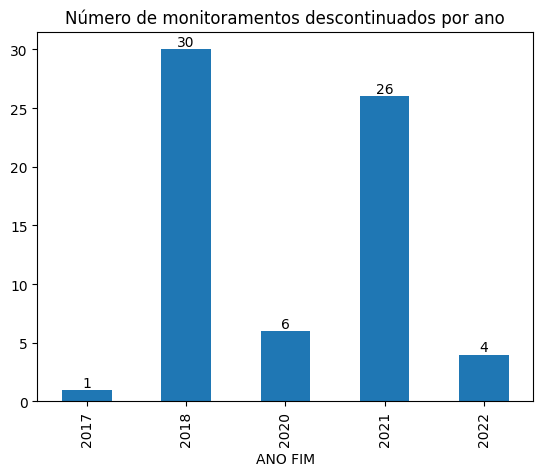

In [14]:
ax = df_files[['ANO', 'CIDADE']].groupby(['CIDADE']).agg({'last'}).droplevel(0, axis = 1)\
        .query("last < 2023").reset_index()[['CIDADE', 'last']]\
        .rename(columns={ 'last': 'ANO FIM'}).groupby(by=['ANO FIM']).count()\
        .plot(kind='bar', title='Número de monitoramentos descontinuados por ano');
ax.bar_label(ax.containers[0]);
ax.legend().remove();

<H1> Arquivos de dados</H1>
<p> Os arquivos de dados estão organizados internamente em dois blocos, o primero com os dados relativos a localização da estação meteorológica (8 primeiras linhas) e o segundo com a tabela das medições. <p>
<p> Cada tabela apresenta medições de 17 indicadores meteorológicos recolhidos a cada hora. Esses dados permitem visualizar informações sobre pluviosidade, temperatura, radiação, umidade, direção e intensidade dos ventos. </p>

<h2>Dados de uma única localidade</h2>

<p> Abaixo podemos ver um exemplo de como podem ser lidos e visualizados os dados históricos de uma cidade. </p>
<p> As primeiras oito linhas (metadados) são descartadas, como também a última coluna, que consiste apenas de espaços em branco no final de cada linha. Como existe uma inconsistência no nome das duas primeiras colunas no decorrer dos anos, elas não são listadas literalmente na seleção de colunas.</p>

In [15]:
def get_city_file_list(city):
    return df_files[df_files['CIDADE'] == city][['ARQUIVO','ANO']]

def read_city_file(file_name, year):
    df = pd.read_csv(f"./{year}/{file_name}", sep=";", decimal=',', skiprows=8, encoding="ANSI").iloc[:, :-1]
    df = df.rename(columns = {df.columns[0]: "Data", df.columns[1]: "Hora_UTC"})
    df['Data'] = df['Data'].astype('datetime64[ns]') 
    
    return df

def process_city_data(df):
    selected_cols = [df.columns[0], df.columns[1],\
        "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",\
        "TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",\
        "TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)",\
        "TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)"]

    df = df[selected_cols].rename(columns= {\
        selected_cols[2]: "Precipitacao_Total_MM",\
        selected_cols[3]: "Temperatura_Ar",\
        selected_cols[4]: "Temperatura_Maxima",\
        selected_cols[5]: "Temperatura_Minima"})

    df = df.sort_values(by='Data').groupby(by='Data').agg({'Hora_UTC': 'last',\
                                        'Precipitacao_Total_MM': lambda x: np.nansum([y if y >= 0 else np.nan for y in x]),\
                                        'Temperatura_Ar': 'mean',\
                                        'Temperatura_Maxima': 'mean',\
                                        'Temperatura_Minima': 'mean',\
                                         })
    return df, df[df["Temperatura_Maxima"].between(-273, 100)]

def process_data_frame(df, processing_function):
    return processing_function(df)


,Data,Hora_UTC,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)"
0,2023-01-01,0000 UTC,0.0,959.3,959.3,958.4,NaN,21.5,20.0,22.3,21.5,20.2,19.8,91.0,86.0,91.0,18.0,1.4,0.5
1,2023-01-01,0100 UTC,0.0,960.1,960.1,959.2,NaN,21.1,19.6,21.8,21.1,20.1,19.5,92.0,90.0,91.0,251.0,1.6,0.7
2,2023-01-01,0200 UTC,0.0,960.6,960.6,960.1,NaN,21.8,19.9,21.8,21.1,20.1,19.5,91.0,89.0,89.0,23.0,4.0,0.7
3,2023-01-01,0300 UTC,0.0,960.2,960.6,960.2,NaN,22.4,18.8,22.4,21.8,19.9,18.8,89.0,80.0,80.0,49.0,5.4,2.4
4,2023-01-01,0400 UTC,0.0,959.9,960.3,959.9,NaN,22.3,19.0,22.7,22.3,19.3,18.6,83.0,78.0,82.0,66.0,5.4,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31,1900 UTC,0.0,955.5,956.4,955.5,1642.3,28.5,20.3,29.1,28.5,21.8,19.8,66.0,58.0,61.0,91.0,3.4,1.2
8756,2023-12-31,2000 UTC,0.0,955.1,955.5,955.1,1018.3,29.1,19.7,29.3,28.0,21.4,19.7,67.0,57.0,57.0,29.0,2.6,1.0
8757,2023-12-31,2100 UTC,0.0,955.1,955.1,954.9,439.3,27.3,21.1,29.1,27.2,21.2,19.5,69.0,57.0,69.0,207.0,2.3,0.7
8758,2023-12-31,2200 UTC,0.0,955.7,955.7,955.1,7.3,25.0,21.6,27.3,25.0,22.0,20.4,82.0,66.0,81.0,268.0,2.2,0.4


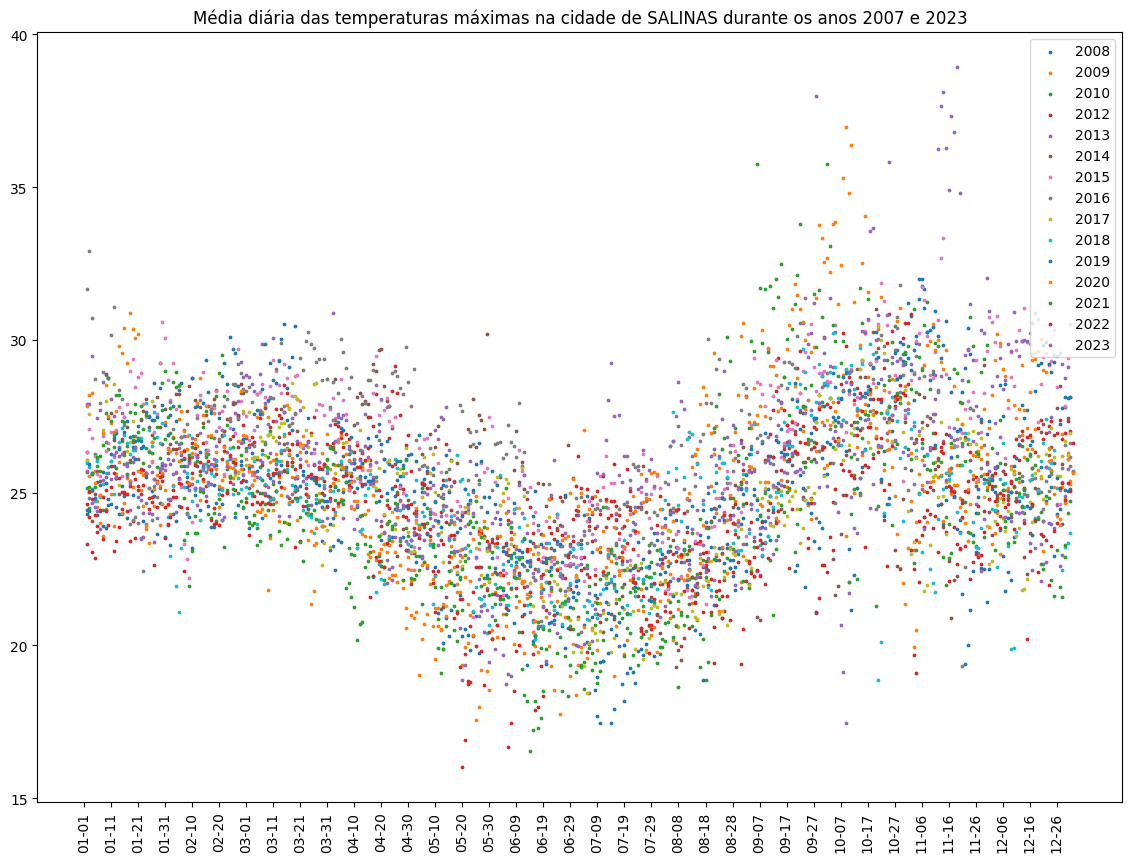

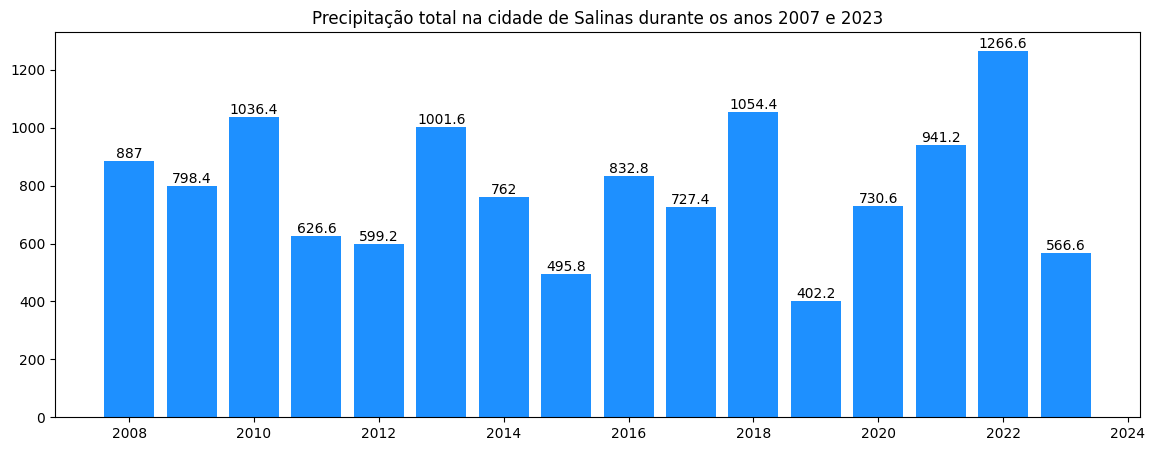

In [16]:
cidade = "SALINAS"
df_cidade = get_city_file_list(cidade)

fig_temp_max, ax_temp_max = plt.subplots(figsize=(14, 10))
fig_precitacao, ax_precipitacao = plt.subplots(figsize=(14, 5))

for i in range(0, len(df_cidade)):
    ano = df_cidade.iloc[i]['ANO']
    df_ano = read_city_file(df_cidade.iloc[i]['ARQUIVO'], ano)
    
    if i == len(df_cidade) - 1:
        display(df_ano)
    
    df_ano, clean = process_data_frame(df_ano, process_city_data)
    if len(df_ano) > 300:
        ax_precipitacao.bar(ano, df_ano['Precipitacao_Total_MM'].sum(), color='dodgerblue')
        ax_precipitacao.bar_label(ax_precipitacao.containers[-1]);
    
    if len(clean) < 300: 
        continue
    
    x_values = [ x.timetuple().tm_yday for x in clean.index]
    ax_temp_max.scatter(x_values, clean['Temperatura_Maxima'], label=ano, s=3)
   
ax_precipitacao.set_title(f"Precipitação total na cidade de Salinas durante os anos {df_cidade.iloc[0]['ANO']} e {df_cidade.iloc[-1]['ANO']}")

labels = [datetime.strptime("2024-" + str(day_num), "%Y-%j").strftime("%m-%d") for day_num in np.arange(1, 367, 10) ]
ax_temp_max.set_xticks(np.arange(0, 366, 10), labels=labels, rotation=90)

ax_temp_max.set_xticklabels(labels)
ax_temp_max.set_title(f"Média diária das temperaturas máximas na cidade de {cidade} durante os anos {df_cidade.iloc[0]['ANO']} e {df_cidade.iloc[-1]['ANO']}")
ax_temp_max.legend(loc = "upper right")
plt.show()

In [17]:
def create_annotations(ax, df):
    ## ESSE CODIGO DEVE SER MELHORADO POSTERIORMENTE
    df_precipitation = df.sort_values(by='PRECIPITACAO')
    df_precipitation = pd.concat([df_precipitation.head(5), df_precipitation.tail(5)])
    for index, row in df_precipitation.iterrows():
        ax.annotate(row['CIDADE'], (row['MEDIA MAX-TEMPERATURA'], row['PRECIPITACAO']))
    
    df_avg_temp = df.sort_values(by='MEDIA MAX-TEMPERATURA')
    df_avg_temp = pd.concat([df_avg_temp.head(5), df_avg_temp.tail(5)])
    for index, row in df_avg_temp.iterrows():
        ax.annotate(row['CIDADE'], (row['MEDIA MAX-TEMPERATURA'], row['PRECIPITACAO']))

    plt.show()
    return [df_precipitation, df_avg_temp]

def create_scatter_precipitation_avg_max_temp(year):
    fig, ax = plt.subplots(figsize=(14, 10))
    rows_list = []
    df_files_year = df_files[df_files['ANO'] == year]
    colors_dict = {'NE': '#1C2A9E', 'S': '#1f680c', 'N': '#F08B19', 'CO': '#a52a2a', 'SE': '#9E721C'}
    city_colors = []
    
    for i in range(0, len(df_files_year)):
        row = df_files_year.iloc[i][['CIDADE', 'ARQUIVO']]
    
        df_ano = read_city_file(df_files_year.iloc[i]['ARQUIVO'], year)
        
        ## ESSE FILTRO É COMPLICADO, POIS UM VALOR NULL PODE SIGNIFICAR ZERO CHUVA OU CHUVA NÃO MEDIDA
        num_nan = np.count_nonzero(df_ano["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"].isnull().values)
        num_zeros = np.count_nonzero(df_ano["PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"] <= 0.001)
        if num_nan > 365*24*0.90:
            continue
        if num_nan + num_zeros > 365*24*0.99:
            continue
    
        df_ano, clean = process_data_frame(df_ano, process_city_data)
    
        if len(clean) < 300:
            continue

        pd.set_option('display.max_rows', None )
            
        precipitation = df_ano['Precipitacao_Total_MM'].fillna(0).sum()
        avg_temp = clean['Temperatura_Maxima'].mean()
        rows_list.append([row['CIDADE'], df_files_year.iloc[i]['REGIAO'], precipitation, avg_temp])
        city_colors.append(colors_dict[df_files_year.iloc[i]['REGIAO']])
    
    df_precipitation_avg_max_temp = pd.DataFrame(columns=['CIDADE', 'REGIAO', 'PRECIPITACAO', 'MEDIA MAX-TEMPERATURA'], data= rows_list)
    df_precipitation_avg_max_temp['REGIAO'] = df_files['REGIAO']
    scatter = ax.scatter(df_precipitation_avg_max_temp['MEDIA MAX-TEMPERATURA'],\
               df_precipitation_avg_max_temp['PRECIPITACAO'], c= city_colors)

    fake_handles = [mpatches.Patch(color=item) for item in colors_dict.values()]
    ax.legend(fake_handles, colors_dict.keys(), loc='upper right', prop={'size': 10})
    
    ax.grid(linestyle = '--')
    ax.set_xlabel("Média de temperaturas máximas (Celsius)")
    ax.set_ylabel("Precipitação anual (mm)")

    return [df_precipitation_avg_max_temp, *create_annotations(ax, df_precipitation_avg_max_temp)]

<h4> Precipitação anual x Temperatura média anual (2013) </h4>

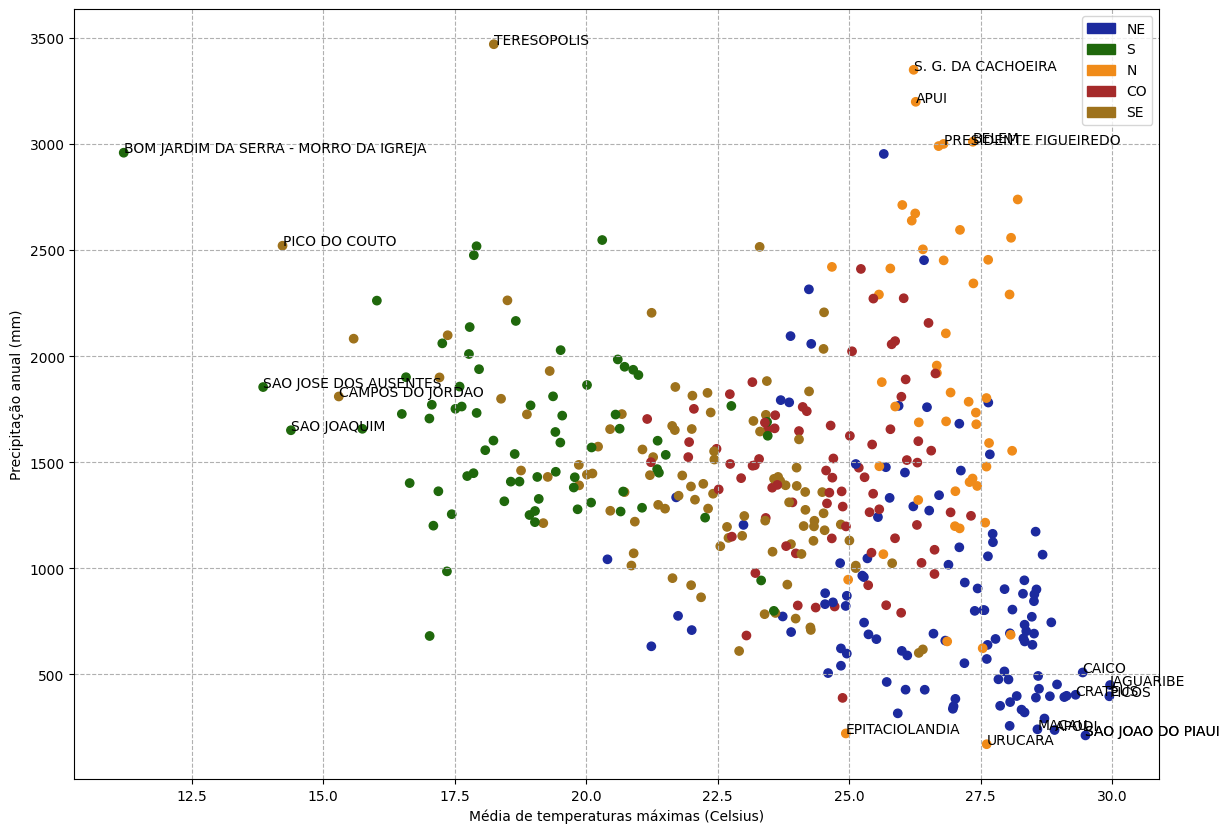

In [18]:
df_precipitation_avg_max_temp, df_precipitation_extremes, df_avg_temp_extremes = create_scatter_precipitation_avg_max_temp(2013)

<h4> Cidades com maior e menor precipitação (2013) </h4>

In [19]:
display(df_precipitation_extremes[["CIDADE", "PRECIPITACAO"]].reset_index(drop=True))

,CIDADE,PRECIPITACAO
0,URUCARA,171.2
1,SAO JOAO DO PIAUI,212.8
2,EPITACIOLANDIA,222.0
3,APODI,238.2
4,MACAU,241.4
5,PRESIDENTE FIGUEIREDO,3000.8
6,BELEM,3011.0
7,APUI,3199.4
8,S. G. DA CACHOEIRA,3350.2
9,TERESOPOLIS,3470.8


<h4> Cidades com maiores e menores médias de temperatura máxima (2013) </h4>

In [20]:
display(df_avg_temp_extremes[["CIDADE", "MEDIA MAX-TEMPERATURA"]].reset_index(drop=True))

,CIDADE,MEDIA MAX-TEMPERATURA
0,BOM JARDIM DA SERRA - MORRO DA IGREJA,11.210534
1,SAO JOSE DOS AUSENTES,13.860829
2,PICO DO COUTO,14.229155
3,SAO JOAQUIM,14.388990
4,CAMPOS DO JORDAO,15.298545
5,CRATEUS,29.304571
6,CAICO,29.439560
7,SAO JOAO DO PIAUI,29.492301
8,PICOS,29.945868
9,JAGUARIBE,29.959945


<h4> Precipitação anual x Temperatura média anual (2023) </h4>

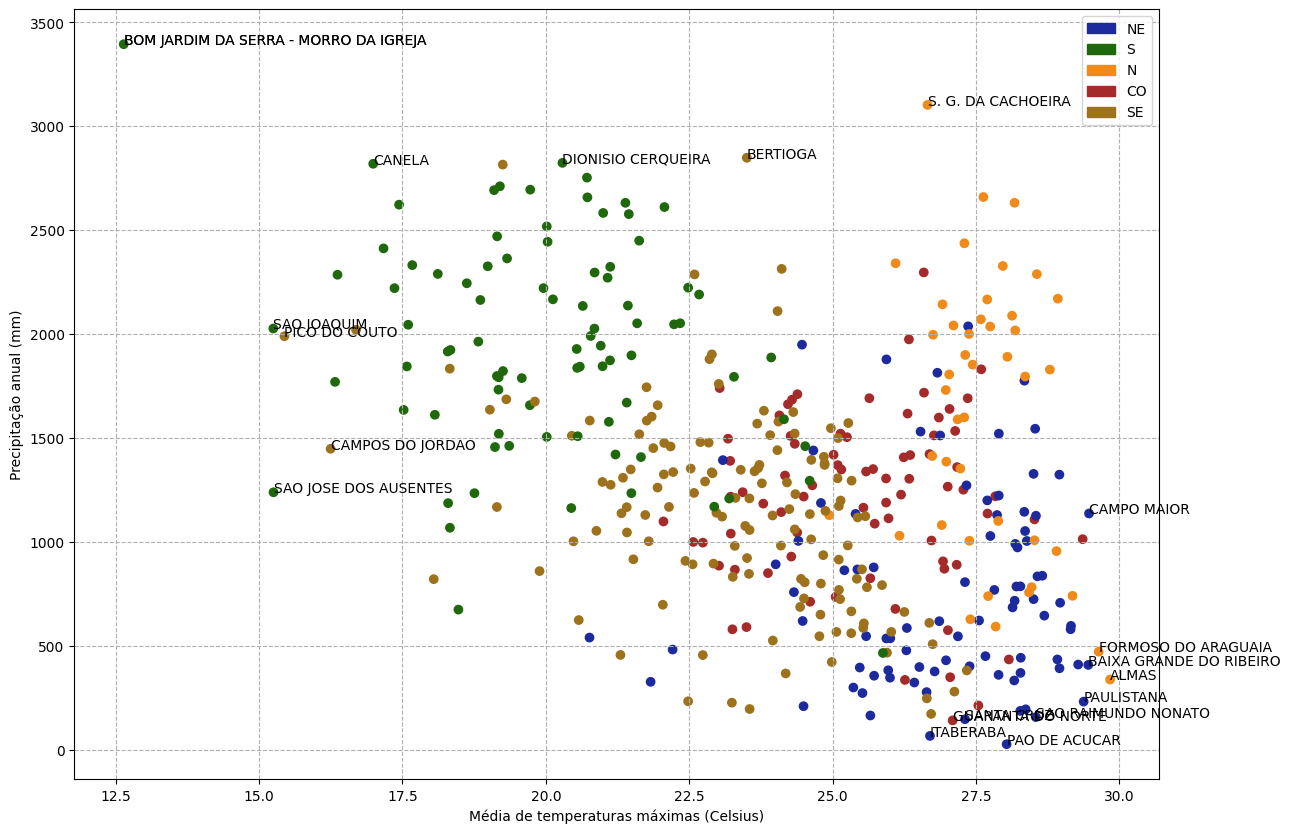

In [21]:
df_precipitation_avg_max_temp, df_precipitation_extremes, df_avg_temp_extremes = create_scatter_precipitation_avg_max_temp(2023)

<h4> Cidades com maior e menor precipitação (2023) </h4>

In [22]:
display(df_precipitation_extremes[["CIDADE", "PRECIPITACAO"]].reset_index(drop=True))

,CIDADE,PRECIPITACAO
0,PAO DE ACUCAR,26.0
1,ITABERABA,66.0
2,GUARANTA DO NORTE,140.6
3,SANTA CRUZ,146.4
4,SAO RAIMUNDO NONATO,156.6
5,CANELA,2818.8
6,DIONISIO CERQUEIRA,2823.4
7,BERTIOGA,2847.8
8,S. G. DA CACHOEIRA,3102.2
9,BOM JARDIM DA SERRA - MORRO DA IGREJA,3394.2


<h4> Cidades com maiores e menores médias de temperatura máxima (2023) </h4>

In [23]:
display(df_avg_temp_extremes[["CIDADE", "MEDIA MAX-TEMPERATURA"]].reset_index(drop=True))

,CIDADE,MEDIA MAX-TEMPERATURA
0,BOM JARDIM DA SERRA - MORRO DA IGREJA,12.638927
1,SAO JOAQUIM,15.247369
2,SAO JOSE DOS AUSENTES,15.251116
3,PICO DO COUTO,15.441243
4,CAMPOS DO JORDAO,16.246543
5,PAULISTANA,29.378318
6,BAIXA GRANDE DO RIBEIRO,29.458810
7,CAMPO MAIOR,29.471836
8,FORMOSO DO ARAGUAIA,29.640588
9,ALMAS,29.839155


<p> Abaixo é possível ver os histogramas que representam a quantidade de locais por faixa de precipitação anual e média de temperatura máxima</p>

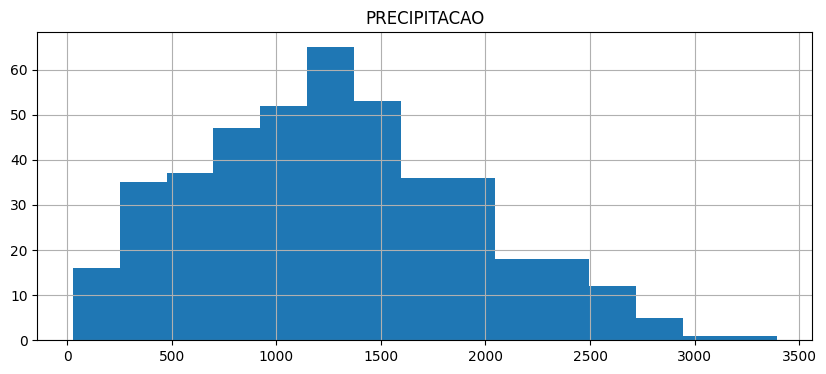

In [24]:
df_precipitation_avg_max_temp.hist("PRECIPITACAO", bins = 15, figsize=(10, 4));

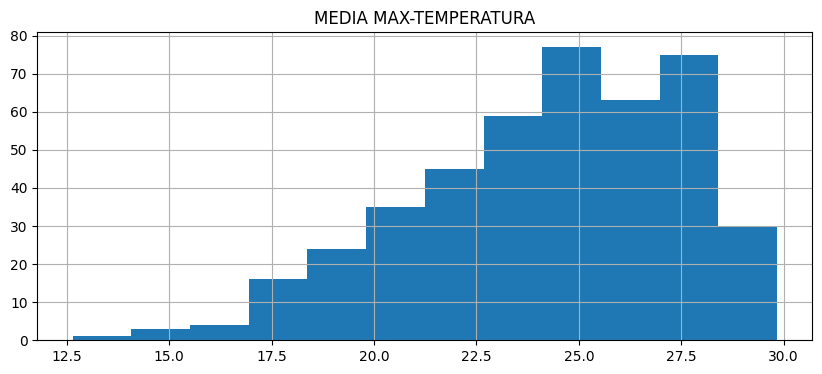

In [25]:
df_precipitation_avg_max_temp.hist("MEDIA MAX-TEMPERATURA", bins = 12, figsize=(10, 4));

<p> Depois do processo de limpeza de dados feito na construção do gráfico scatter a distribuição de cidades por região é a seguinte: </p>

In [26]:
display(df_precipitation_avg_max_temp[['CIDADE', 'REGIAO']].groupby(by='REGIAO').count().rename(columns = {'CIDADE': 'NUMERO DE CIDADES'}))

,NUMERO DE CIDADES
REGIAO,
CO,139
N,22
NE,95
S,59
SE,117


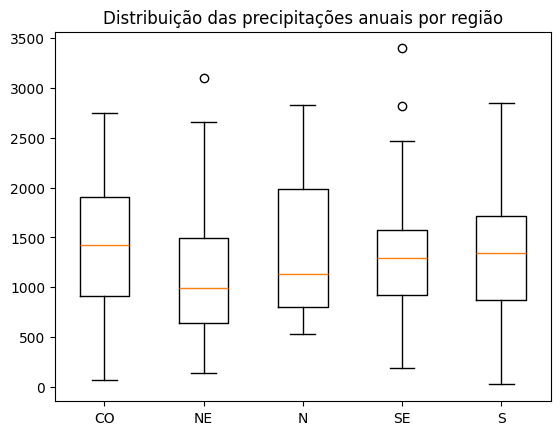

In [27]:
grouped_data = [df_precipitation_avg_max_temp[df_precipitation_avg_max_temp['REGIAO'] == region]['PRECIPITACAO'] for region in df_precipitation_avg_max_temp['REGIAO'].unique()]

# Create the box plot
plt.boxplot(grouped_data, tick_labels=df_precipitation_avg_max_temp['REGIAO'].unique());
plt.title("Distribuição das precipitações anuais por região");

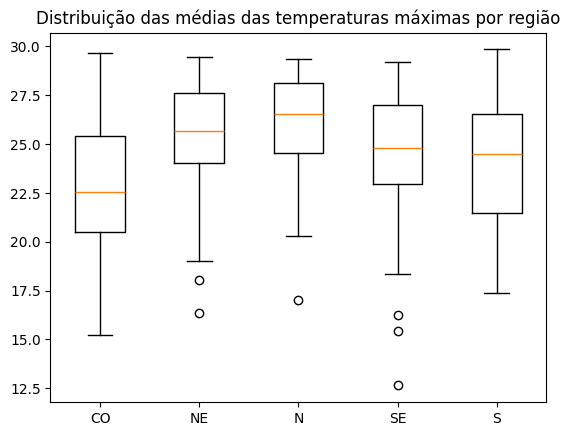

In [28]:
grouped_data = [df_precipitation_avg_max_temp[df_precipitation_avg_max_temp['REGIAO'] == region]['MEDIA MAX-TEMPERATURA'] for region in df_precipitation_avg_max_temp['REGIAO'].unique()]

# Create the box plot
plt.boxplot(grouped_data, tick_labels=df_precipitation_avg_max_temp['REGIAO'].unique());
plt.title("Distribuição das médias das temperaturas máximas por região");

In [29]:
def calculate_region_probability_by_temperature_and_precipitation(df):
    temp_bins = np.arange(10, 41, 8)  
    rain_bins = np.arange(0, 4501, 500) 
    
    df['Intervalo Temperatura (Celsius)'] = pd.cut(df['MEDIA MAX-TEMPERATURA'], bins=temp_bins, right=False)
    df['Intervalor Precipitacao (mm)'] = pd.cut(df['PRECIPITACAO'], bins=rain_bins, right=False)
    
    counts = df.groupby(['Intervalor Precipitacao (mm)', 'Intervalo Temperatura (Celsius)', 'REGIAO'], observed= False)\
               .size().unstack(fill_value=0)
    
    probabilities = 100*counts.div(counts.sum(axis=1), axis=0).fillna(0)
    # REMOVE COLUMNS WITH ALL ZERO VALUES
    probabilities = probabilities.loc[(probabilities!=0).any(axis=1)]
    
    display(HTML('<h4> Probabilidade condicional de uma cidade estar situada em uma região dada a médida de temperaturas máximas e a pluviosidade anual </h4>'))
    display(probabilities.style.highlight_max(color = 'lightgreen', axis = 1).apply_index(color, axis=0, level =[0]).format(precision=1))
    
calculate_region_probability_by_temperature_and_precipitation(df_precipitation_avg_max_temp)

<p> A tabela acima traz alguns indícios de como é o clima em cada região brasileira. Em particular podemos observer que: </p>
<ul>
    <li> O centro-oeste não tem regiões super-úmidas, com precipitações anuais acima de 3.000 milimetros. </li>
    <li> O centro-oeste porém concentra o maior número de locais com climas de baixa temperatura, principalmente ligado a altas precipitações. </li>
    <li> Não são observadas precipitações anuais de menos de 1000 milímetros na região Norte. </li>
    <li> A região norte se destaca quando o nível de precipitação é acima de 2000 milímetros. </li>
    <li> A região sudeste, mesmo com um grande número de cidades monitoradas, não apresenta uma tendência majoritária em climas muito úmidos. </li>
</ul>

<p> Entretando é importante salientar que essas tabela considera apenas um conjunto muito limitado de dados: dados de um único ano (2023), pouquíssimos locais de medição (menos de 10% das cidades brasileiras) e distribuição desequilibrada das estações (que se concentram principalmente nas regiões sudeste e centro-oeste neste amostra). Além disso, é notoria a ausência de dados, mesmo depois da filtragem realizada em etapas anteriores da análise. </p>
